<HR>
<HR>
<B> <h2>➡️TASK 10 : FACIAL MOOD RECOGNITION ⬅️</B>
    <HR>
    <HR>

<B>➡️Importing libraries⬅️</B>

In [15]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

<B>➡️Tensorflow ver check⬅️</B>

In [16]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.6.4
Num GPUs Available:  1


<B>➡️Kaggle sourcethrough⬅️</B>

In [17]:
os.environ['KAGGLE_USERNAME'] ="samrocks03" # username from the json file
os.environ['KAGGLE_KEY'] = "e41225bb36673b4038b4316b25cb7a00" # key from the json file

In [18]:
!kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [21]:
!ls

__notebook_source__.ipynb  dataset1  fer2013.zip  song


In [22]:
!ls dataset/

ls: cannot access 'dataset/': No such file or directory


In [23]:
!ls dataset1/train

angry  disgust	fear  happy  neutral  sad  surprise


<B>➡️Training data⬅️</B>

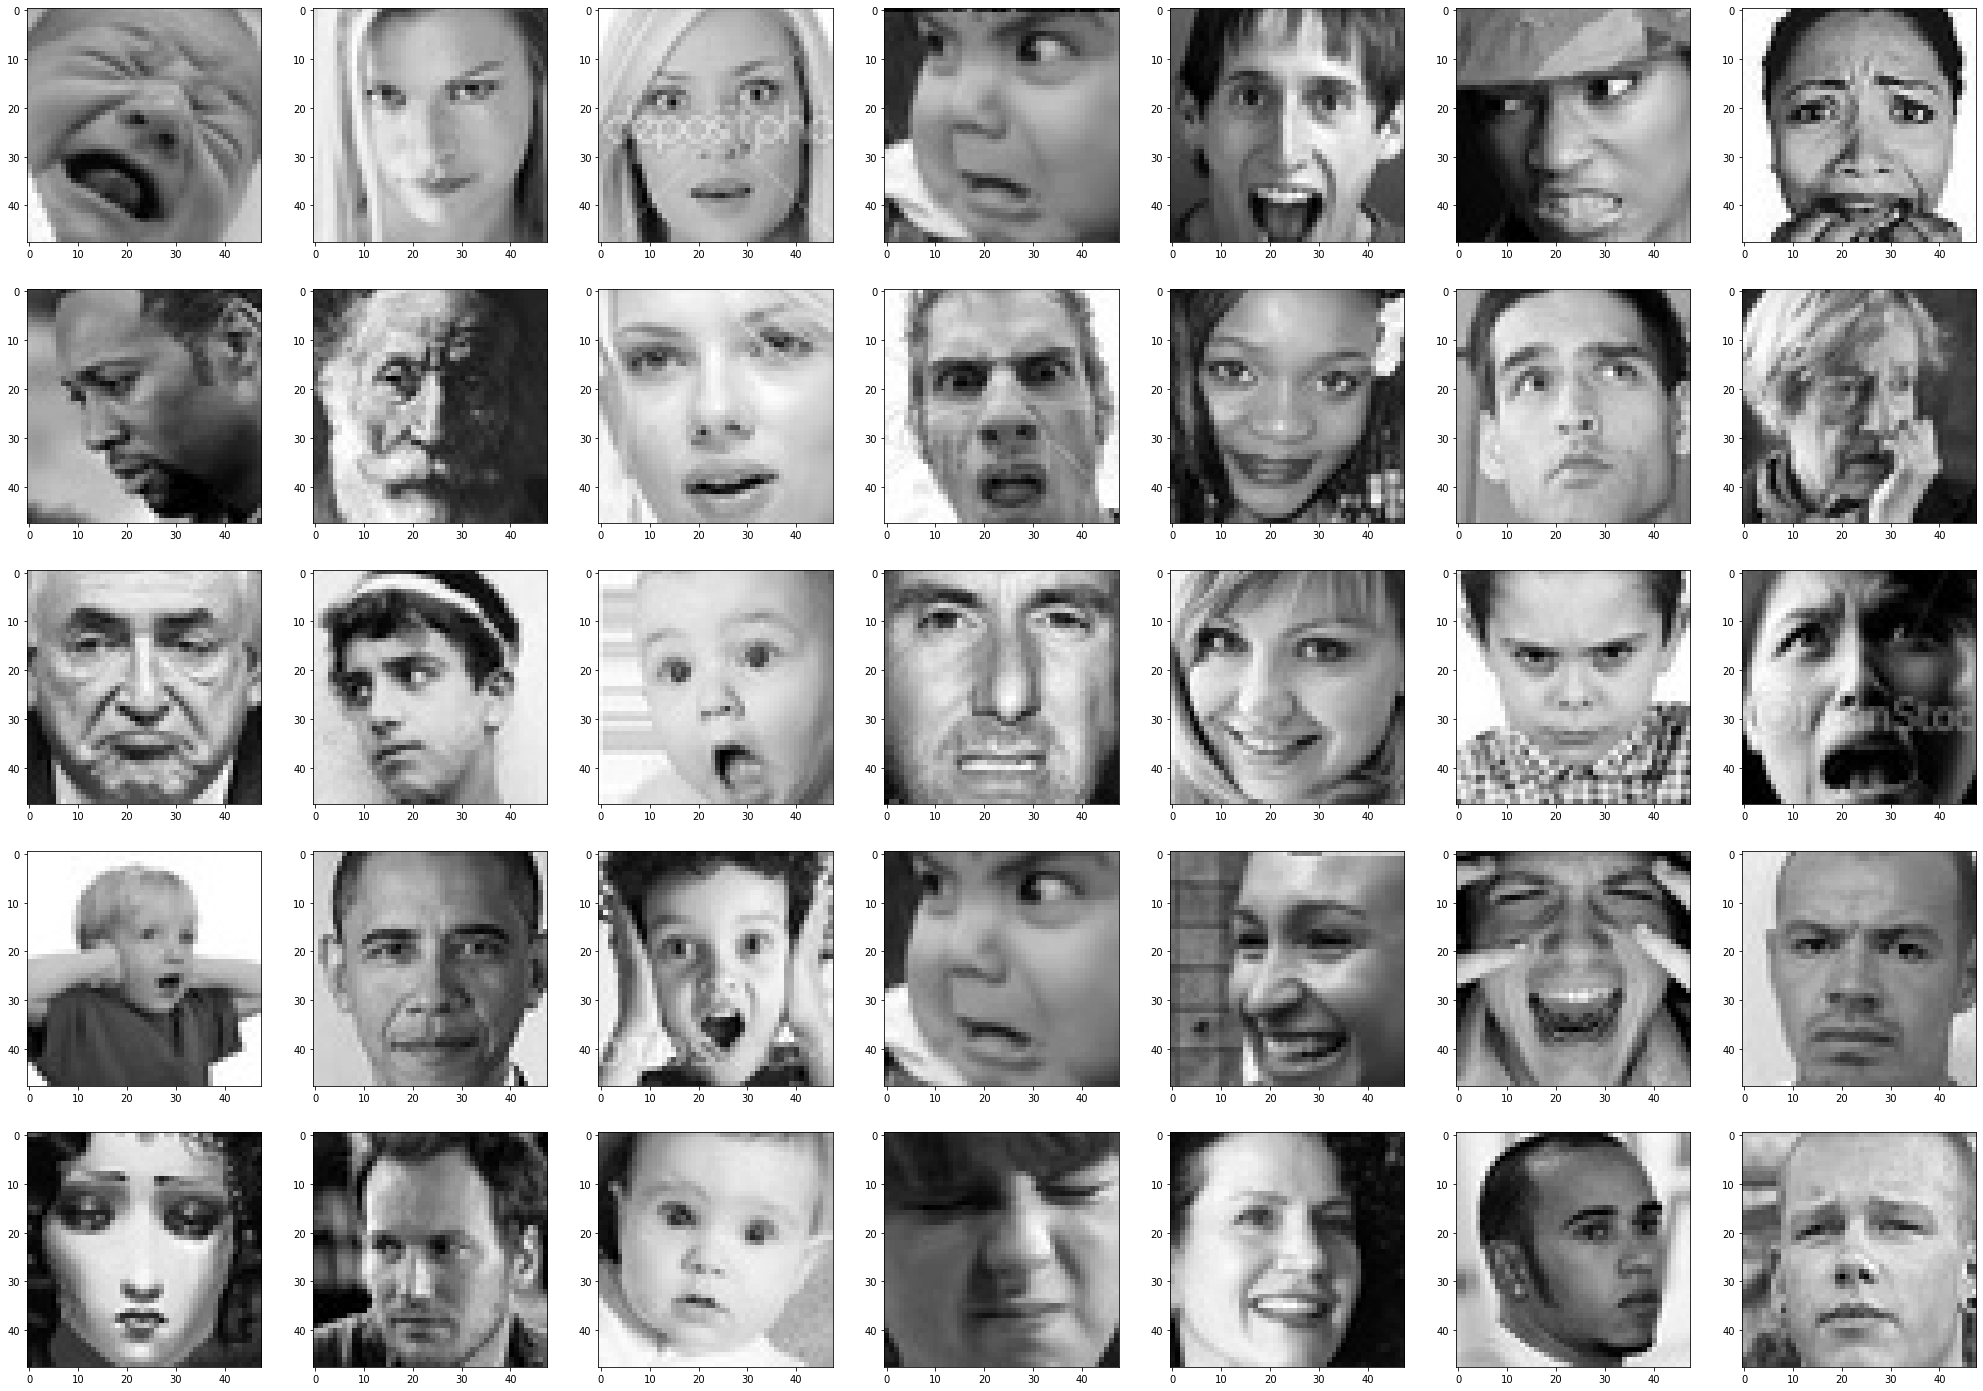

In [24]:
from skimage.io import imread
train_dir = "dataset1/train/"
test_dir = "dataset1/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

<B>➡️Total images of each label⬅️</B>

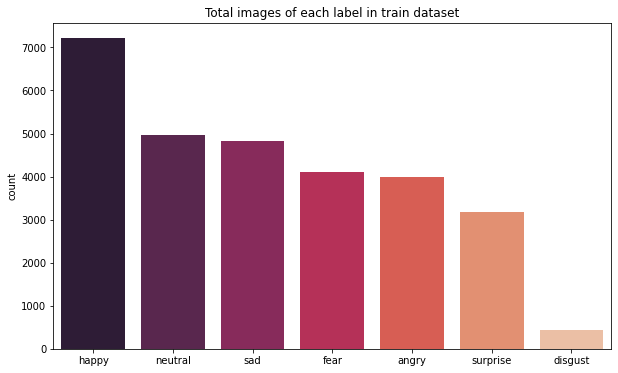

In [25]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="rocket", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


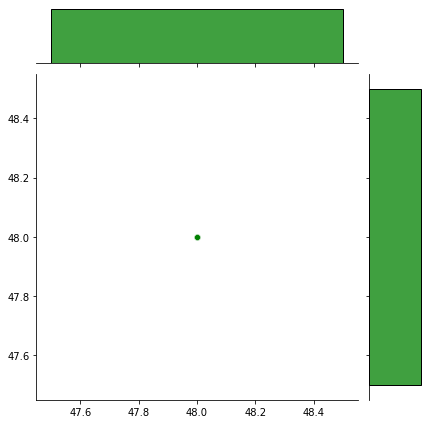

In [26]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1, dim2,color='g')
plt.show()

In [27]:
train_gen = ImageDataGenerator(rescale=1/255,rotation_range=40,
                                width_shift_range=0.2,height_shift_range=0.2,
                                shear_range=0.2,zoom_range=0.2,
                                horizontal_flip=True,fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),color_mode='grayscale',
                                                batch_size=64,class_mode='categorical',shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),color_mode='grayscale',
                                                batch_size=64,class_mode='categorical',shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


<B><h3>➡️Training the model⬅️</B>

In [28]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

2022-10-01 11:21:37.115856: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-01 11:21:37.116369: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 11:21:37.117380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-01 11:21:37.118161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
              loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 20

history = model.fit(train_generator,epochs=num_epochs,verbose=1,#callbacks=callbacks,
                    validation_data=test_generator,steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20


2022-10-01 11:21:39.984880: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-01 11:21:41.745380: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


448/448 [==============================] - 36s 63ms/step - loss: 1.8777 - accuracy: 0.2312 - val_loss: 2.3197 - val_accuracy: 0.2072
Epoch 2/20
448/448 [==============================] - 27s 61ms/step - loss: 1.8002 - accuracy: 0.2493 - val_loss: 1.7886 - val_accuracy: 0.2715
Epoch 3/20
448/448 [==============================] - 27s 60ms/step - loss: 1.7850 - accuracy: 0.2603 - val_loss: 1.7586 - val_accuracy: 0.2900
Epoch 4/20
448/448 [==============================] - 28s 62ms/step - loss: 1.7719 - accuracy: 0.2680 - val_loss: 1.6984 - val_accuracy: 0.3083
Epoch 5/20
448/448 [==============================] - 27s 61ms/step - loss: 1.7525 - accuracy: 0.2803 - val_loss: 1.7913 - val_accuracy: 0.3235
Epoch 6/20
448/448 [==============================] - 27s 60ms/step - loss: 1.7292 - accuracy: 0.2939 - val_loss: 1.9444 - val_accuracy: 0.3188
Epoch 7/20
448/448 [==============================] - 27s 60ms/step - loss: 1.6935 - accuracy: 0.3152 - val_loss: 1.5742 - val_accuracy: 0.3878
Epo

In [31]:
model.save("model.h5")

In [32]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 2s 21ms/step - loss: 1.2231 - accuracy: 0.5237
validation accuracy : 52.368348836898804%
validation loss : 1.2231336832046509


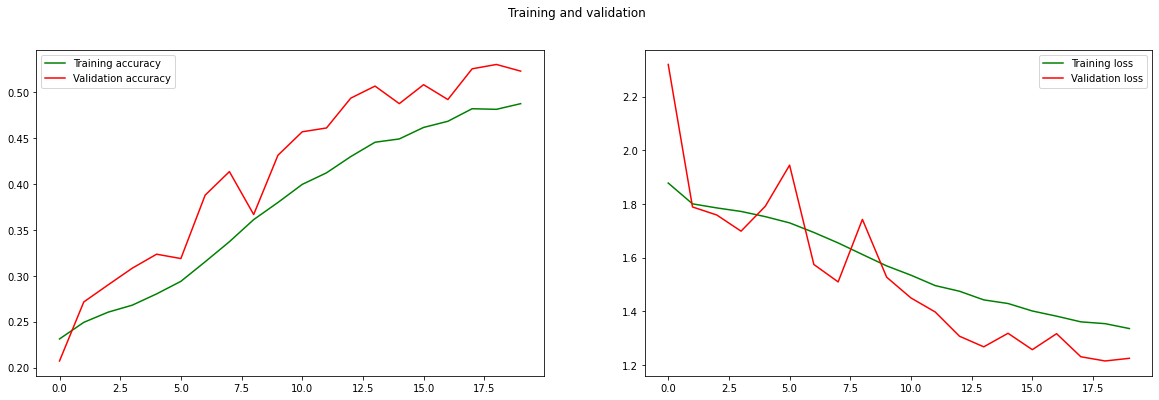

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

<b>➡️Confusion Matrix⬅️</b>

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.37      0.52      0.43       958
     disgust       0.00      0.00      0.00       111
        fear       0.32      0.21      0.26      1024
       happy       0.75      0.84      0.79      1774
     neutral       0.49      0.50      0.50      1233
         sad       0.43      0.22      0.30      1247
    surprise       0.52      0.79      0.63       831

    accuracy                           0.52      7178
   macro avg       0.41      0.44      0.41      7178
weighted avg       0.50      0.52      0.50      7178





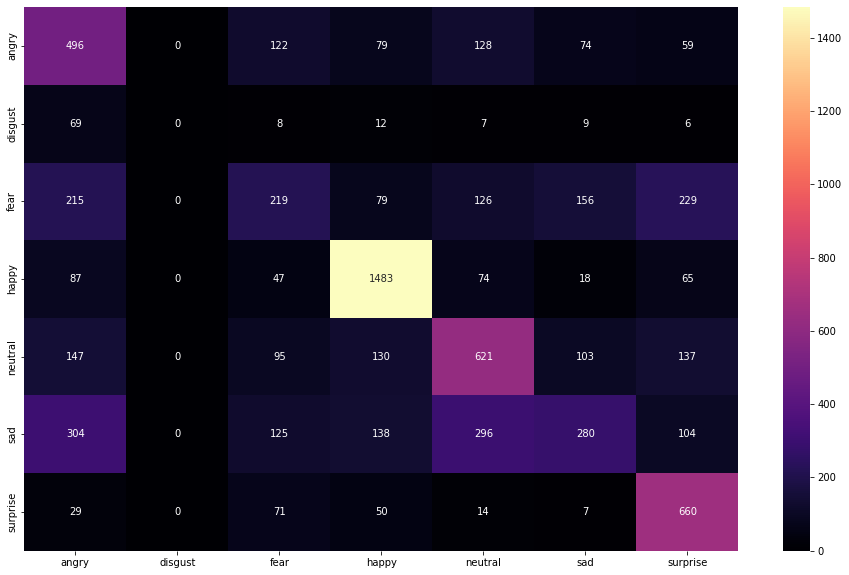

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.magma, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

<b>➡️Read Image⬅️</b>

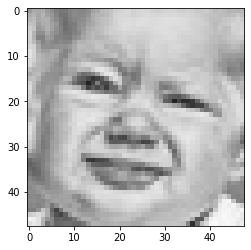

In [48]:
image = cv2.imread("dataset1/train/angry/Training_73556209.jpg")
from IPython.display import Image
Image(filename='dataset1/train/angry/Training_73556209.jpg') 
plt.imshow(image)
plt.show()

<b>➡️Predicting mood of image⬅️</b>

In [36]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model
model = load_model("model.h5")
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

  Angry   prediction rate is   0.43%
 Disgust  prediction rate is   0.09%
  Happy   prediction rate is   0.14%
   Sad    prediction rate is   0.03%
 Surprise prediction rate is   0.08%
 Neutral  prediction rate is   0.22%


 The system considers this expression to be: Angry


<b>➡️Playing song⬅️</b>

In [44]:
if(label=='Angry'):
    path="..//input//songszip//songs//Angry//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Angry//'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="..//input//songszip//songs//Disgust//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Disgust//'+ d,autoplay=True)
    display(audio)
    
elif (label=="Happy"):
    path="..//input//songszip//songs//Happy//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Happy//'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="..//input//songszip//songs//Happy//Sad//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Happy//Sad//'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="..//input//songszip//songs//Surprise//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Surprise//'+ d,autoplay=True)
    display(audio)
    
elif (label=='Neutral'):
    path="..//input//songszip//songs//Neutral//"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='..//input//songszip//songs//Neutral//'+ d,autoplay=True)
    display(audio)

Now Playing: Angry Mood Off-Bgm.mp3
